Notes:
 * revised and tuned configuration, updated views
 * training on full dataset (including Y3, new light curves, fixes)

In [48]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/revised_tuned_33_run_1'
val_data_files = '/mnt/tess/astronet/tfrecords-33-val/*'
train_data_files = '/mnt/tess/astronet/tfrecords-33-train/*'
tces_file = '/mnt/tess/astronet/tces-v10-val.csv'

nruns = 1

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/revised_tuned_33_run_1/1/AstroCNNModel_revised_tuned_20211220_011636']

In [49]:
import getpass
import os
import pandas as pd
from astronet.astro_cnn_model import input_ds
from astronet.util import config_util
from astronet.astro_cnn_model import astro_cnn_model
import tensorflow as tf


def run_embeddings(path, data_files):
    model = tf.keras.models.load_model(path)
    config = config_util.load_config(path)
    model = astro_cnn_model.AstroCNNModel(config, model, embeds_only=True)
    
    ds = input_ds.build_dataset(
        file_pattern=data_files,
        input_config=config.inputs,
        batch_size=1,
        include_labels=False,
        shuffle_filenames=False,
        repeat=1,
        include_identifiers=True)
    
    label_index = {i:k.lower() for i, k in enumerate(config.inputs.label_columns)}

    print('0 records', end='')
    series = []
    for features, identifiers in ds:
      preds = model(features)

      row = {}
      row['tic_id'] = identifiers.numpy().item()
      row['preds'] = preds.numpy()

      series.append(row)
      print('\r{} records'.format(len(series)), end='')

    results = pd.DataFrame.from_dict(series)
    
    return results, config



paths = load_ensemble(chkpt_root, nruns)
ensemble_embeds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_embeddings(path, val_data_files)
    ensemble_embeds.append(preds.set_index('tic_id'))
    print()
    
ensemble_embeds_train = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_embeddings(path, train_data_files)
    ensemble_embeds_train.append(preds.set_index('tic_id'))
    print()

Running model 1
2487 records
Running model 1
19869 records


In [50]:
import numpy as np

ref = ensemble_embeds[0].loc[158159741]['preds']

df = ensemble_embeds_train[0]
df['l2'] = df.apply(lambda row: np.sum(np.power((row['preds'] - ref), 2)), axis=1)

In [51]:
df = df.sort_values(by=['l2'])

In [52]:
df.head(15)

,preds,l2
tic_id,,
278448537,"[[0.0, 0.04562311, 0.29386842, 0.16317376, 0.0...",1.257077
401726741,"[[0.0, 0.065150514, 0.2046843, 0.14915243, 0.0...",1.268455
316992468,"[[0.0, 0.0, 0.19163358, 0.108853824, 0.0, 0.22...",1.299712
98148702,"[[0.0, 0.0007847026, 0.25487578, 0.3286, 0.041...",1.331499
268631245,"[[0.0, 0.04262328, 0.23359843, 0.3083856, 0.04...",1.351098
105352509,"[[0.0, 0.06147389, 0.21281435, 0.2629048, 0.08...",1.430478
142385396,"[[0.0, 0.0, 0.21958353, 0.21425602, 0.03761888...",1.515349
233798897,"[[0.0, 0.030538727, 0.21197361, 0.12973097, 0....",1.576169
353215176,"[[0.0, 0.053672962, 0.18818104, 0.105406664, 0...",1.594314


In [3]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
2487 records
Running model 2
2487 records
Running model 3
2487 records
Running model 4
2487 records
Running model 5
2487 records
Running model 6
2487 records
Running model 7
2487 records
Running model 8
2487 records
Running model 9
2487 records
Running model 10
2487 records


In [52]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.31

In [53]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [54]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [55]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [56]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9845559845559846
Precision: 0.6873315363881402


In [57]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

104485403
369264198
141753278
158159741


In [58]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

416282321
43306175
64418963
136651206
260976846
277848886
417208086
431416493
252588526
431338538
60959009
192591652
279064110
312060273
332870317
347492958
381847922
450006142
94280922
127846210
261814771
269291226
408945155
428942240
55244346
648359612
82242456
142751024
147607082
159528102
356822358
377253895
405687343
48025487
101496204
122577745
213841827
238829802
241855882
335588842
36492008
385229393
389661615
74885707
80466845
842068824
56861756
91987762
138847344
14826027
150384768
157272202
55778419
154271808
159636125
219824182
332298341
399167691
284266496
298647682
164528404
113496703
118139893
118398402
161030195
167039826
177163343
201601338
238200877
25133152
261205462
270312112
270505202
271999852
273654759
276738707
278409392
291374558
293527927
294205251
30407196
306772814
30722286
309650507
311103813
31636802
31868634
319865847
320356995
326693475
373919592
379191982
384341508
38570890
38679633
404851508
404851552
404851966
404934011
40602499
406091286
407615704
41

In [59]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 349412074)

,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,
349412074,0.005532,0.139427,0.976235,0.000313,0.013968
349412074,0.427455,0.131023,0.513995,0.004392,0.014265
349412074,0.001926,0.092980,0.986855,0.000158,0.003637
349412074,0.004343,0.254761,0.982789,0.000083,0.001301
349412074,0.017558,0.210889,0.932013,0.001502,0.005387
349412074,0.007434,0.146385,0.970903,0.001354,0.008450
349412074,0.051197,0.243218,0.860501,0.000993,0.004133
349412074,0.009396,0.245522,0.953337,0.000326,0.002855
349412074,0.004178,0.220315,0.970821,0.000307,0.008755


In [60]:
pl[pl.index == 421845505]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,,,,,,,


### PR curve

In [61]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_e']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [62]:
num_cond_pos = float(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9771417706489333, max R: 1.0, max P: 1.0
100% recall at: 19%, threshold: 0.003995827674920294


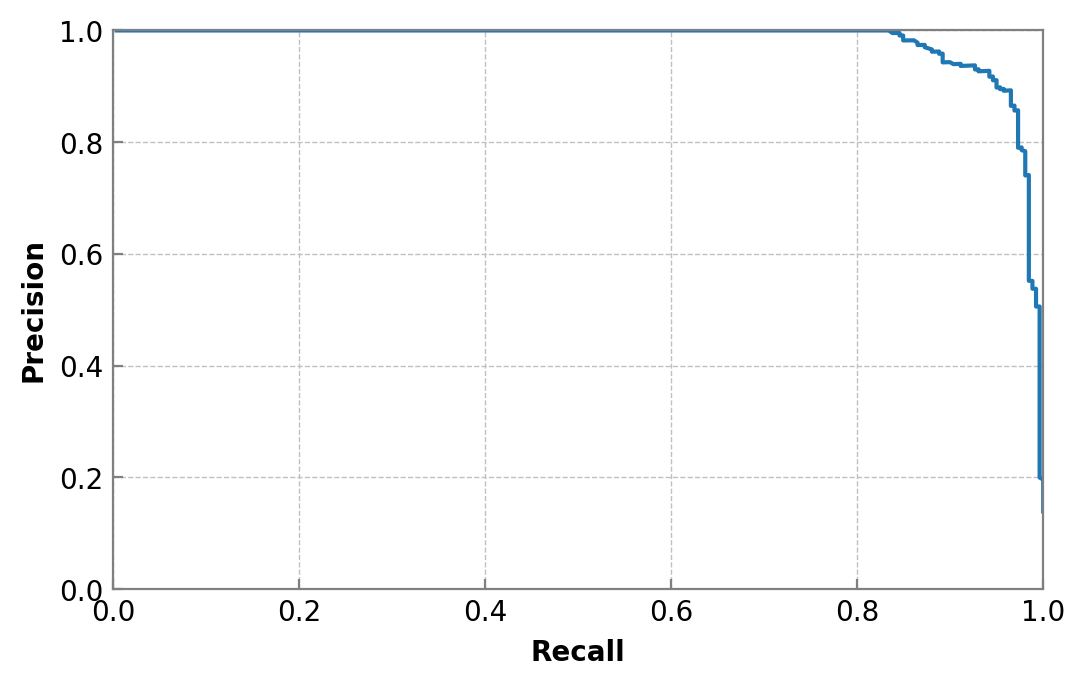

In [64]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    if p > 0:
        ps.append(p)
        rs.append(r)
    else:
        ps.append(1.0)
        rs.append(0.0)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)